In [1]:
import os
import supervision as sv
import ultralytics
from ultralytics import YOLO
from IPython import display
import cv2
import torch
import numpy as np
import time
from typing import Callable

In [2]:
import sys
sys.path.append('../YOLOv6')

In [3]:
from yolov6.data.data_augment import letterbox
from yolov6.layers.common import DetectBackend
from yolov6.utils.events import LOGGER
from yolov6.utils.nms import non_max_suppression
from yolov6.utils.events import load_yaml

In [4]:
from supervision import VideoInfo, VideoSink, Detections

In [5]:
from supervision.detection.utils import extract_ultralytics_masks

In [6]:
res = {
    "lost_track_buffer": [],
    "processing_time": [],
    "fps": [],
    "in_count": [],
    "out_count": [],
}

In [7]:
def process_video(
    source_path: str,
    target_path: str,
    callback: Callable[[np.ndarray, int], np.ndarray],
    start: int = 0,
    end: int = 0,
    stride: int = 1,
) -> None:
    """
    Process a video file by applying a callback function on each frame
        and saving the result to a target video file.

    Args:
        source_path (str): The path to the source video file.
        target_path (str): The path to the target video file.
        callback (Callable[[np.ndarray, int], np.ndarray]): A function that takes in
            a numpy ndarray representation of a video frame and an
            int index of the frame and returns a processed numpy ndarray
            representation of the frame.

    Examples:
        ```python
        import supervision as sv

        def callback(scene: np.ndarray, index: int) -> np.ndarray:
            ...

        process_video(
            source_path='...',
            target_path='...',
            callback=callback
        )
        ```
    """
    source_video_info = VideoInfo.from_video_path(video_path=source_path)
    with VideoSink(target_path=target_path, video_info=source_video_info) as sink:
        for index, frame in enumerate(
            sv.get_video_frames_generator(source_path, start=start, end=end, stride=stride)
        ):
            result_frame = callback(frame, index)
            sink.write_frame(frame=result_frame)

In [8]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [9]:
model = DetectBackend('../models/yolov6s.pt', device=device)

Loading checkpoint from ../models/yolov6s.pt

Fusing model...


In [10]:
stride = model.stride
img_size = [640, 640]  # standard size
half = False
model.model.float()

class_names = load_yaml('../datasets/coco.yaml')['names']

In [11]:
resolution = '640x640'
date = '15_04_25'
time_h = '7-8'
catalog = 'Aerodynamika'
video_name = f'Aerodynamika_{resolution}.mp4'

In [12]:
start = 0
end = 4200
frame_stride = 5

In [13]:
def process_frame(frame):
    image = letterbox(frame, img_size, stride=stride)[0]
    image = image.transpose((2, 0, 1))[::-1].copy()  # BGR to RGB, HWC to CHW
    image = torch.from_numpy(image).float() / 255.0
    image = image.unsqueeze(0)  # add batch dimension
    
    if half:
        image = image.half()
    
    image = image.to(device)
    return image

In [14]:
SOURCE_VIDEO_PATH = f"/Users/grzegorzsmereczniak/Documents/MyPW/data/monitoring_pw/{date}/{time_h}/{catalog}/resized/{video_name}"
RESULTS_PATH = f"/Users/grzegorzsmereczniak/Documents/MyPW/results/monitoring_pw/{date}/{time_h}/{catalog}/yolov6"

In [15]:
CLASS_NAMES_DICT = class_names

SELECTED_CLASS_NAMES = ['person']

SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [16]:
CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [17]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=2200, end=2205, stride=stride)

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

iterator = iter(generator)
frame = next(iterator)
processed_frame = process_frame(frame)

In [18]:
processed_frame.shape

torch.Size([1, 3, 640, 640])

In [19]:
def get_results(model, frame):
    with torch.no_grad():
        pred = model(frame)
        det = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45,classes=[0])[0]
    
    xyxy = det[:, :4].cpu().numpy().astype('float32')
    confidence = det[:, 4].cpu().numpy().astype('float32')
    class_id = det[:, 5].cpu().numpy().astype(int)
    mask = None
    tracker_id = None

    return (xyxy, confidence, class_id, mask, tracker_id)

In [20]:
results = get_results(model, processed_frame)

In [21]:
def get_detections(xyxy, confidence, class_id, mask, tracker_id):
    return Detections(
        xyxy=xyxy,
        confidence=confidence,
        class_id=class_id,
        mask=None,
        tracker_id=tracker_id
    )

In [22]:
detections = get_detections(*get_results(model, processed_frame))

In [23]:
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

In [24]:
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

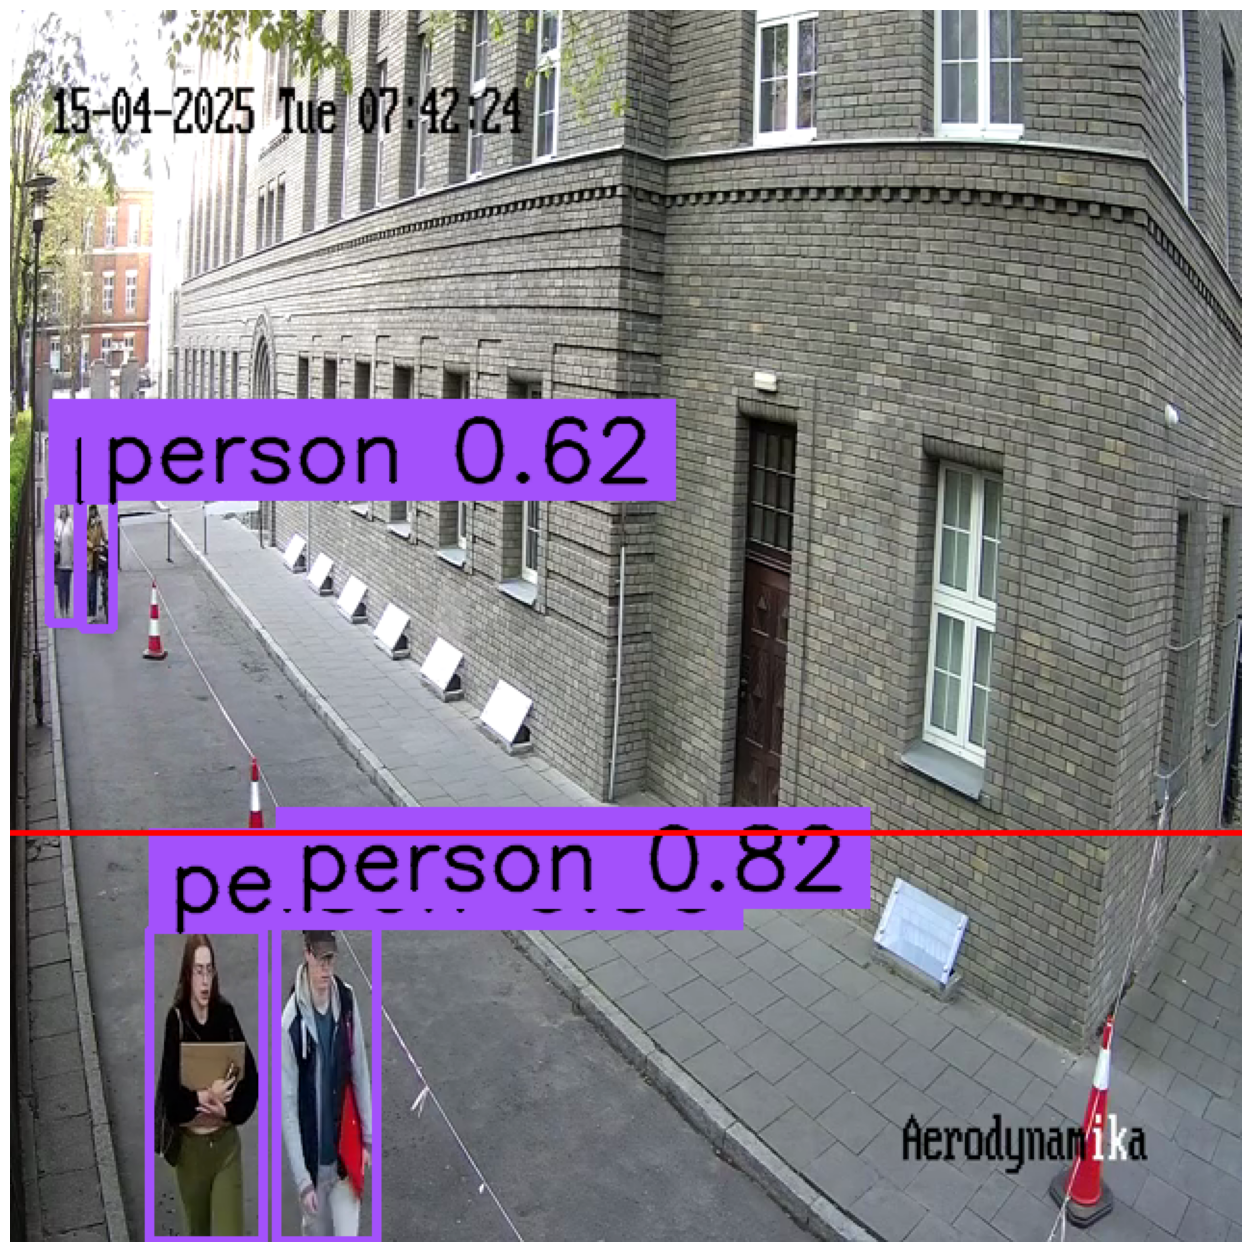

In [25]:
coord1 = (0, 427)
coord2 = (640, 427)
cv2.line(annotated_frame, coord1, coord2, color=(0, 0, 255), thickness=2)

# ▶️ Display the frame
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [26]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=640, height=640, fps=14, total_frames=50331)

In [27]:
LINE_START = sv.Point(*coord1)
LINE_END = sv.Point(*coord2)

In [28]:
# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2, text_orient_to_line=True)

start_time = time.time()
video_name = f"stride_{frame_stride}_{video_name}"

TARGET_VIDEO_PATH = os.path.join(RESULTS_PATH, f"{video_name}")

# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=video_info.fps,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # results = get_results(model, process_frame(frame)),
    detections = get_detections(*get_results(model, process_frame(frame)))
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback,
    start=start,
    end=end,
    stride=frame_stride
)

end_time = time.time()
elapsed_time = end_time - start_time

in_count = line_zone.in_count
out_count = line_zone.out_count

res['processing_time'].append(elapsed_time)
res['fps'].append(video_info.fps)
res['in_count'].append(in_count)
res['out_count'].append(out_count)

In [29]:
res

{'lost_track_buffer': [],
 'processing_time': [38.02608275413513],
 'fps': [14],
 'in_count': [0],
 'out_count': [6]}